In [1]:
import pyro
import torch
import wandb
import os

from inference.bayesian.models import TorchModel, HorseshoeSSVS
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [512, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "inference": "ssvs",
            "num_samples": 5000,
            "num_chains": 2,
            "plot": False,
            "sweep": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Run ESN on dataset and produce embeddings with or without dimensionality reduction according to `dim_reduction`

In [4]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 10512, Val: 5256, Te: 5256


# Stochastic Search Variable Selection


Perform SSVS on embeddings with no dimensionality reduction.

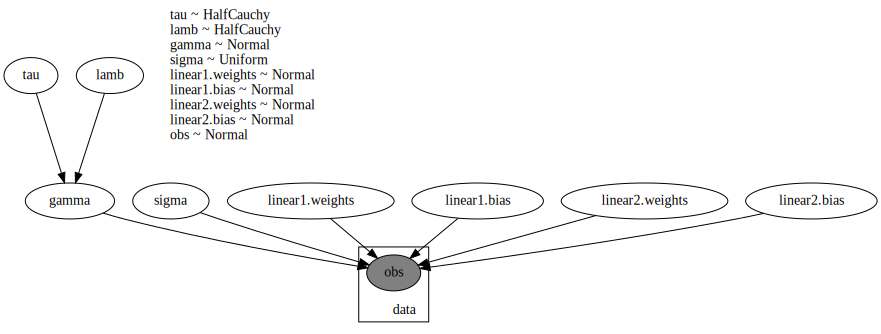

In [5]:
# Define the horseshoe SSVS model
# type = 'm' for 'manual' linear layer, type = 't' for torch.nn.linear
ssvs_model = HorseshoeSSVS(train_embedding.shape[1], 1, type='m', device=device)

pyro.render_model(ssvs_model, model_args=(train_embedding[0], Ytr[0]), render_distributions=True, filename=None)

In [6]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [8]:
# Run Markov chains and collect diagnostics
predictive, diagnostics = inference(config, ssvs_model, None,
                                    X_train=train_embedding, Y_train=Ytr,
                                    X_val=val_embedding, Y_val=Yval, 
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

Sample: 100%|██████████| 5000/5000 [01:00, 82.53it/s, step size=1.95e-03, acc. prob=0.010]


Checking convergence...
Chain 0 completed.
Chain 1 completed.
MCMC converged at 0 steps.


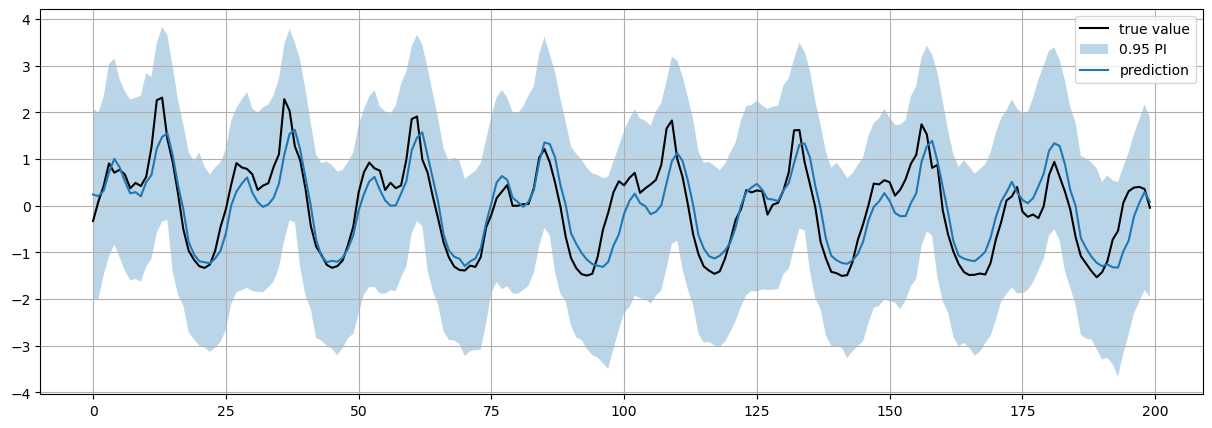

In [9]:
plot_forecast(predictive, Yte, "ssvs")

In [8]:
for k, v in diagnostics.items():
    print(k)

step_size
acceptance_rate
train_time
effective_sample_size
split_gelman_rubin
autocorrelation
quantiles
cal_error
crps


In [11]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])

training time:  65.39963948299997
calibration error:  0.4393422258594366
Continuous ranked probability score:  0.3246365666767971


In [21]:
# to reload a package or method
import sys, importlib

importlib.reload(sys.modules['bayesian.utils'])

from inference.bayesian.utils import plot_forecast

In [23]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')